In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
# Cài đặt để hiển thị biểu đồ ngay trong notebook (nếu cần)
%matplotlib inline
import statsmodels.api as sm
# Cài đặt để Pandas hiển thị nhiều cột/dòng hơn (tùy chọn)
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA as StatsmodelsARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
# from statsmodels.tsa.ets.api import ETSModel # Bỏ comment nếu statsmodels đủ mới
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print("Các thư viện đã được import.")

Các thư viện đã được import.


In [9]:
# --- PHẦN 1: ĐỌC VÀ TIỀN XỬ LÝ DỮ LIỆU CHUNG ---

print("--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU ---")

# 1.1. Đọc dữ liệu từ file CSV
file_path = 'World GDP Dataset.csv'
try:
    df_raw_initial = pd.read_csv(file_path) # Đọc thô ban đầu để lấy thông tin kích thước
    # Đọc lại với xử lý na_values cho các bước sau
    df_raw = pd.read_csv(file_path, na_values=['0', 0.0])
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file '{file_path}'. Vui lòng kiểm tra lại đường dẫn.")
    raise
except Exception as e:
    print(f"Lỗi khi đọc file CSV: {e}")
    raise
print("Đọc dữ liệu thô thành công.")

print("\n--- THỐNG KÊ DỮ LIỆU THÔ BAN ĐẦU (df_raw_initial - TRƯỚC KHI XỬ LÝ SÂU) ---")
rows_raw_initial, cols_raw_initial = df_raw_initial.shape
elements_raw_initial = df_raw_initial.size # Tổng số phần tử
print(f"Số hàng ban đầu (từ file CSV): {rows_raw_initial}")
print(f"Số cột ban đầu (từ file CSV): {cols_raw_initial}")
print(f"Tổng số phần tử ban đầu: {elements_raw_initial}")
print("5 dòng đầu của dữ liệu thô ban đầu:")
display(df_raw_initial.head())


# 1.2. Làm sạch cơ bản (áp dụng cho df_raw)
df_raw.dropna(how='all', inplace=True) # Loại bỏ các dòng hoàn toàn trống
# Loại bỏ dòng copyright nếu có (dựa trên cấu trúc file bạn cung cấp)
# Đếm số dòng bị loại bỏ bởi copyright
rows_before_copyright_removal = len(df_raw)
df_raw = df_raw[~df_raw.iloc[:, 0].astype(str).str.contains("©IMF", na=False)]
rows_after_copyright_removal = len(df_raw)
print(f"\nLàm sạch cơ bản: Loại bỏ {rows_before_copyright_removal - rows_after_copyright_removal} dòng copyright/footer.")

country_col_original_name = df_raw.columns[0]
df_raw.rename(columns={country_col_original_name: 'Country Name'}, inplace=True)
print("Đổi tên cột quốc gia hoàn tất.")

print("\n--- THỐNG KÊ DỮ LIỆU SAU LÀM SẠCH CƠ BẢN (df_raw - TRƯỚC KHI MELT) ---")
rows_raw_cleaned, cols_raw_cleaned = df_raw.shape
elements_raw_cleaned = df_raw.size
print(f"Số hàng sau làm sạch cơ bản: {rows_raw_cleaned}")
print(f"Số cột sau làm sạch cơ bản (vẫn là định dạng wide): {cols_raw_cleaned}")
print(f"Tổng số phần tử sau làm sạch cơ bản: {elements_raw_cleaned}")
print("5 dòng đầu của dữ liệu sau làm sạch cơ bản:")
display(df_raw.head())


# 1.3. Chuyển từ định dạng wide sang long
try:
    df_long = pd.melt(df_raw,
                      id_vars=['Country Name'],
                      var_name='Year',
                      value_name='GDP')
except KeyError as e:
    print(f"Lỗi khi chuyển đổi wide sang long: Cột 'Country Name' hoặc các cột năm không đúng. {e}")
    print("Kiểm tra lại tên cột đầu tiên trong file CSV của bạn.")
    raise
print("\nChuyển đổi dữ liệu từ wide sang long thành công.")
print("--- THỐNG KÊ DỮ LIỆU SAU KHI MELT (df_long - TRƯỚC KHI CHUYỂN KIỂU VÀ DROPNA) ---")
rows_after_melt, cols_after_melt = df_long.shape
elements_after_melt = df_long.size
print(f"Số hàng sau khi melt: {rows_after_melt}") # Sẽ là rows_raw_cleaned * (cols_raw_cleaned - 1)
print(f"Số cột sau khi melt: {cols_after_melt}") # Sẽ là 3 cột: 'Country Name', 'Year', 'GDP'
print(f"Tổng số phần tử sau khi melt: {elements_after_melt}")
display(df_long.head())


# 1.4. Chuyển đổi kiểu dữ liệu
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
if df_long['GDP'].dtype == 'object':
    df_long['GDP'] = df_long['GDP'].astype(str).str.replace(',', '', regex=False)
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')
print("\nChuyển đổi kiểu dữ liệu cho 'Year' và 'GDP' hoàn tất.")

# 1.5. Xử lý giá trị thiếu (NaN)
# Lưu lại số dòng trước khi dropna để so sánh
rows_before_final_dropna = len(df_long)
df_long.dropna(subset=['Year', 'GDP'], inplace=True)
rows_after_final_dropna = len(df_long)
print(f"Xử lý giá trị thiếu cuối cùng: Số dòng trước khi loại bỏ NaN ở 'Year'/'GDP' (sau chuyển kiểu): {rows_before_final_dropna}")
print(f"Số dòng sau khi loại bỏ NaN cuối cùng: {rows_after_final_dropna}")
print(f"Số dòng đã bị loại bỏ do NaN ở 'Year'/'GDP' hoặc do '0' ban đầu: {rows_before_final_dropna - rows_after_final_dropna}")


# 1.6. Sắp xếp dữ liệu
df_long.sort_values(by=['Country Name', 'Year'], inplace=True)
df_long.reset_index(drop=True, inplace=True)
print("\nSắp xếp dữ liệu theo Quốc gia và Năm hoàn tất.")

print("\n\n--- TIỀN XỬ LÝ DỮ LIỆU HOÀN TẤT (df_long CUỐI CÙNG) ---")
print("--- THỐNG KÊ CHI TIẾT VỀ df_long SAU TẤT CẢ CÁC BƯỚC XỬ LÝ ---")

# Số hàng và số cột
num_rows_final, num_cols_final = df_long.shape
elements_final = df_long.size
print(f"Số hàng (quan sát) cuối cùng: {num_rows_final}")
print(f"Số cột (đặc trưng) cuối cùng: {num_cols_final}")
print(f"Tổng số phần tử cuối cùng: {elements_final}")

# Tên các cột
print(f"Tên các cột cuối cùng: {df_long.columns.tolist()}")

# Kiểu dữ liệu của từng cột
print("\nKiểu dữ liệu của các cột cuối cùng:")
print(df_long.dtypes)

# Số lượng giá trị duy nhất cho mỗi cột
print("\nSố lượng giá trị duy nhất cho mỗi cột cuối cùng:")
for col in df_long.columns:
    print(f"  - {col}: {df_long[col].nunique()}")

# Kiểm tra giá trị thiếu (NaN) sau tất cả các bước
print("\nKiểm tra giá trị thiếu (NaN) trong df_long cuối cùng:")
print(df_long.isnull().sum())

# Thống kê mô tả cho các cột số (Year và GDP)
print("\nThống kê mô tả cho các cột số cuối cùng:")
display(df_long.describe())

# Phạm vi thời gian cụ thể
min_year = df_long['Year'].min()
max_year = df_long['Year'].max()
print(f"\nPhạm vi năm trong dữ liệu cuối cùng: Từ {int(min_year)} đến {int(max_year)}")

# Số lượng quốc gia
num_unique_countries = df_long['Country Name'].nunique()
print(f"Tổng số quốc gia có dữ liệu cuối cùng: {num_unique_countries}")

# Hiển thị một vài dòng đầu và cuối để kiểm tra
print("\n5 dòng đầu của df_long cuối cùng:")
display(df_long.head())


--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU ---
Đọc dữ liệu thô thành công.

--- THỐNG KÊ DỮ LIỆU THÔ BAN ĐẦU (df_raw_initial - TRƯỚC KHI XỬ LÝ SÂU) ---
Số hàng ban đầu (từ file CSV): 230
Số cột ban đầu (từ file CSV): 45
Tổng số phần tử ban đầu: 10350
5 dòng đầu của dữ liệu thô ban đầu:


,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,20.616,20.057,18.020,18.883,18.401,18.876,20.136,0.000,0.000,0.000
1,Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,...,13.246,11.389,11.862,13.053,15.157,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,...,213.810,165.979,160.034,170.207,175.372,171.680,144.922,162.711,187.155,190.254
3,Andorra,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,3.267,2.789,2.895,2.993,3.217,3.155,2.885,3.330,3.302,3.360
4,Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,...,145.712,116.194,101.124,122.022,101.353,84.516,58.125,75.179,124.794,135.558



Làm sạch cơ bản: Loại bỏ 1 dòng copyright/footer.
Đổi tên cột quốc gia hoàn tất.

--- THỐNG KÊ DỮ LIỆU SAU LÀM SẠCH CƠ BẢN (df_raw - TRƯỚC KHI MELT) ---
Số hàng sau làm sạch cơ bản: 196
Số cột sau làm sạch cơ bản (vẫn là định dạng wide): 45
Tổng số phần tử sau làm sạch cơ bản: 8820
5 dòng đầu của dữ liệu sau làm sạch cơ bản:


,Country Name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.616,20.057,18.020,18.883,18.401,18.876,20.136,NaN,NaN,NaN
1,Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,...,13.246,11.389,11.862,13.053,15.157,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,...,213.810,165.979,160.034,170.207,175.372,171.680,144.922,162.711,187.155,190.254
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.267,2.789,2.895,2.993,3.217,3.155,2.885,3.330,3.302,3.360
4,Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,...,145.712,116.194,101.124,122.022,101.353,84.516,58.125,75.179,124.794,135.558



Chuyển đổi dữ liệu từ wide sang long thành công.
--- THỐNG KÊ DỮ LIỆU SAU KHI MELT (df_long - TRƯỚC KHI CHUYỂN KIỂU VÀ DROPNA) ---
Số hàng sau khi melt: 8624
Số cột sau khi melt: 3
Tổng số phần tử sau khi melt: 25872


,Country Name,Year,GDP
0,Afghanistan,1980,NaN
1,Albania,1980,1.946
2,Algeria,1980,42.346
3,Andorra,1980,NaN
4,Angola,1980,6.639



Chuyển đổi kiểu dữ liệu cho 'Year' và 'GDP' hoàn tất.
Xử lý giá trị thiếu cuối cùng: Số dòng trước khi loại bỏ NaN ở 'Year'/'GDP' (sau chuyển kiểu): 8624
Số dòng sau khi loại bỏ NaN cuối cùng: 7852
Số dòng đã bị loại bỏ do NaN ở 'Year'/'GDP' hoặc do '0' ban đầu: 772

Sắp xếp dữ liệu theo Quốc gia và Năm hoàn tất.


--- TIỀN XỬ LÝ DỮ LIỆU HOÀN TẤT (df_long CUỐI CÙNG) ---
--- THỐNG KÊ CHI TIẾT VỀ df_long SAU TẤT CẢ CÁC BƯỚC XỬ LÝ ---
Số hàng (quan sát) cuối cùng: 7852
Số cột (đặc trưng) cuối cùng: 3
Tổng số phần tử cuối cùng: 23556
Tên các cột cuối cùng: ['Country Name', 'Year', 'GDP']

Kiểu dữ liệu của các cột cuối cùng:
Country Name     object
Year              int64
GDP             float64
dtype: object

Số lượng giá trị duy nhất cho mỗi cột cuối cùng:
  - Country Name: 196
  - Year: 44
  - GDP: 7052

Kiểm tra giá trị thiếu (NaN) trong df_long cuối cùng:
Country Name    0
Year            0
GDP             0
dtype: int64

Thống kê mô tả cho các cột số cuối cùng:


,Year,GDP
count,7852.000000,7852.000000
mean,2002.741722,263.121139
std,12.397475,1245.564570
min,1980.000000,0.014000
25%,1993.000000,3.260250
50%,2003.000000,15.974000
75%,2013.000000,99.016500
max,2023.000000,26185.210000



Phạm vi năm trong dữ liệu cuối cùng: Từ 1980 đến 2023
Tổng số quốc gia có dữ liệu cuối cùng: 196

5 dòng đầu của df_long cuối cùng:


,Country Name,Year,GDP
0,Afghanistan,2002,4.367
1,Afghanistan,2003,4.553
2,Afghanistan,2004,5.146
3,Afghanistan,2005,6.167
4,Afghanistan,2006,6.925




--- BẮT ĐẦU M1_2_LR_Lags_PolyTrend CHO VIETNAM ---
Sử dụng 3 lags, Đặc trưng năm bậc 2. Log transform GDP: False
Đã lọc dữ liệu cho Vietnam. Số dòng ban đầu: 44


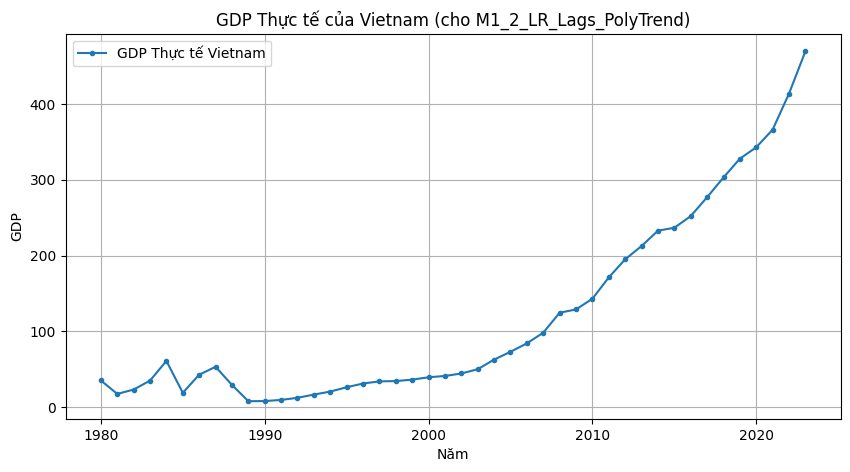


Đã tạo các đặc trưng: ['GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'Year_Feat', 'Year_Sq_Feat'].

Số dòng dữ liệu của Vietnam sau khi tạo features và dropna: 41

--- Đặc trưng X cho Mô hình 1.2 (5 dòng đầu) ---


,GDP_lag1,GDP_lag2,GDP_lag3,Year_Feat,Year_Sq_Feat
0,23.369,17.617,35.357,1983,3932289
1,35.204,23.369,17.617,1984,3936256
2,61.171,35.204,23.369,1985,3940225
3,19.045,61.171,35.204,1986,3944196
4,43.009,19.045,61.171,1987,3948169


Các cột đặc trưng: ['GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'Year_Feat', 'Year_Sq_Feat']

--- Mục tiêu y cho Mô hình 1.2 (5 dòng đầu) ---


,0,1,2,3,4
GDP,35.204,61.171,19.045,43.009,53.385


In [10]:
# --- CELL C1.M1_2: MÔ HÌNH 1.2 (LR VỚI LAGS & TREND POLY) - ĐỊNH NGHĨA THAM SỐ VÀ CHUẨN BỊ DỮ LIỆU ---

# === THAM SỐ CHUNG CHO MÔ HÌNH NÀY ===
MODEL_ID_M1_2 = "M1_2_LR_Lags_PolyTrend"
COUNTRY_M1_2 = 'Vietnam' # <<--- THAY ĐỔI QUỐC GIA Ở ĐÂY
TEST_SIZE_RATIO_M1_2 = 0.25
N_FUTURE_YEARS_M1_2 = 5
NUM_LAGS_M1_2 = 3 # <<--- THỬ NGHIỆM VỚI SỐ LAGS KHÁC NHAU (ví dụ: 2, 3, 4, 5)
POLY_DEGREE_M1_2 = 2 # <<--- BẬC ĐA THỨC CHO NĂM (1 cho Year, 2 cho Year+Year^2, 3 cho Year+Year^2+Year^3)
USE_LOG_TRANSFORM_M1_2 = False # <<--- ĐẶT True ĐỂ THỬ BIẾN ĐỔI LOGARIT CHO GDP
# ==========================================

if USE_LOG_TRANSFORM_M1_2:
    MODEL_ID_M1_2 += "_Log"

print(f"\n\n--- BẮT ĐẦU {MODEL_ID_M1_2} CHO {COUNTRY_M1_2.upper()} ---")
print(f"Sử dụng {NUM_LAGS_M1_2} lags, Đặc trưng năm bậc {POLY_DEGREE_M1_2}. Log transform GDP: {USE_LOG_TRANSFORM_M1_2}")

# 1. Lọc dữ liệu cho quốc gia được chọn
if 'df_long' not in locals() or df_long.empty:
    print(f"Lỗi: df_long chưa được tạo hoặc rỗng. Vui lòng chạy Cell 2 trước.")
    X_m1_2, y_m1_2, country_data_processed_m1_2, feature_columns_m1_2, country_data_lr_m1_2 = None, None, None, None, None
else:
    country_data_lr_m1_2 = df_long[df_long['Country Name'] == COUNTRY_M1_2].copy()
    country_data_lr_m1_2.sort_values('Year', inplace=True)
    country_data_lr_m1_2.reset_index(drop=True, inplace=True)

    if country_data_lr_m1_2.empty or len(country_data_lr_m1_2) < NUM_LAGS_M1_2 + 10:
        print(f"Không đủ dữ liệu cho '{COUNTRY_M1_2}' ({len(country_data_lr_m1_2)} điểm) để tạo {NUM_LAGS_M1_2} lags và xây dựng {MODEL_ID_M1_2}.")
        X_m1_2, y_m1_2, country_data_processed_m1_2, feature_columns_m1_2 = None, None, None, None
    else:
        print(f"Đã lọc dữ liệu cho {COUNTRY_M1_2}. Số dòng ban đầu: {len(country_data_lr_m1_2)}")
        
        # (Tùy chọn) Áp dụng Log Transform cho GDP (và sẽ áp dụng cho lags sau)
        target_gdp_col = 'GDP'
        if USE_LOG_TRANSFORM_M1_2:
            # Kiểm tra giá trị GDP > 0 trước khi log
            if (country_data_lr_m1_2['GDP'] <= 0).any():
                print("CẢNH BÁO: Có giá trị GDP không dương, không thể áp dụng log transform trực tiếp. Bỏ qua log transform.")
                # Hoặc bạn có thể thêm một lượng nhỏ: np.log(country_data_lr_m1_2['GDP'] + 1e-9)
                # Tạm thời bỏ qua nếu có giá trị không dương
                actual_use_log_transform = False
            else:
                country_data_lr_m1_2['GDP_Log'] = np.log(country_data_lr_m1_2['GDP'])
                target_gdp_col = 'GDP_Log' # Mục tiêu giờ là GDP_Log
                print("Đã áp dụng Log Transform cho cột GDP.")
                actual_use_log_transform = True
        else:
            actual_use_log_transform = False


        plt.figure(figsize=(10, 5))
        plt.plot(country_data_lr_m1_2['Year'], country_data_lr_m1_2[target_gdp_col], marker='.', linestyle='-', label=f'{target_gdp_col} Thực tế {COUNTRY_M1_2}')
        plt.title(f'{target_gdp_col} Thực tế của {COUNTRY_M1_2} (cho {MODEL_ID_M1_2})'); plt.xlabel('Năm'); plt.ylabel(f'{target_gdp_col}'); plt.grid(True); plt.legend(); plt.show()

        # 2. Tạo các đặc trưng
        feature_columns_m1_2 = []
        
        # 2a. Tạo đặc trưng trễ (lag features) cho cột mục tiêu (GDP hoặc GDP_Log)
        for i in range(1, NUM_LAGS_M1_2 + 1):
            col_name = f'{target_gdp_col}_lag{i}'
            country_data_lr_m1_2[col_name] = country_data_lr_m1_2[target_gdp_col].shift(i)
            feature_columns_m1_2.append(col_name)
        
        # 2b. Tạo đặc trưng từ Năm (Year, Year^2, Year^3, tùy theo POLY_DEGREE_M1_2)
        # Cột 'Year' đã có sẵn trong country_data_lr_m1_2
        if POLY_DEGREE_M1_2 >= 1:
            country_data_lr_m1_2['Year_Feat'] = country_data_lr_m1_2['Year']
            feature_columns_m1_2.append('Year_Feat')
        if POLY_DEGREE_M1_2 >= 2:
            country_data_lr_m1_2['Year_Sq_Feat'] = country_data_lr_m1_2['Year'] ** 2
            feature_columns_m1_2.append('Year_Sq_Feat')
        if POLY_DEGREE_M1_2 >= 3:
            country_data_lr_m1_2['Year_Cub_Feat'] = country_data_lr_m1_2['Year'] ** 3
            feature_columns_m1_2.append('Year_Cub_Feat')
        
        print(f"\nĐã tạo các đặc trưng: {feature_columns_m1_2}.")
        
        # 3. Xử lý giá trị NaN (do tạo lags)
        country_data_processed_m1_2 = country_data_lr_m1_2.dropna().copy()
        country_data_processed_m1_2.reset_index(drop=True, inplace=True)

        if len(country_data_processed_m1_2) < len(feature_columns_m1_2) + 5: # Cần đủ dữ liệu
            print(f"Không đủ dữ liệu cho '{COUNTRY_M1_2}' ({len(country_data_processed_m1_2)} dòng) sau khi tạo features và dropna để xây dựng {MODEL_ID_M1_2}.")
            X_m1_2, y_m1_2 = None, None
        else:
            print(f"\nSố dòng dữ liệu của {COUNTRY_M1_2} sau khi tạo features và dropna: {len(country_data_processed_m1_2)}")
            
            # 4. Chuẩn bị X (features) và y (target)
            y_m1_2 = country_data_processed_m1_2[target_gdp_col] # Sử dụng cột mục tiêu đã (hoặc chưa) log transform
            X_m1_2 = country_data_processed_m1_2[feature_columns_m1_2]

            print("\n--- Đặc trưng X cho Mô hình 1.2 (5 dòng đầu) ---"); display(X_m1_2.head())
            print(f"Các cột đặc trưng: {X_m1_2.columns.tolist()}")
            print("\n--- Mục tiêu y cho Mô hình 1.2 (5 dòng đầu) ---"); display(y_m1_2.head().to_frame().T)

In [11]:
# --- CELL C2.M1_2: {MODEL_ID_M1_2} - CHIA TRAIN/TEST VÀ HUẤN LUYỆN ---

model_lr_poly_m1_2 = None 
X_train_m1_2, X_test_m1_2, y_train_m1_2, y_test_m1_2 = None, None, None, None
years_train_m1_2, years_test_m1_2 = None, None

if 'X_m1_2' in locals() and X_m1_2 is not None and \
   'y_m1_2' in locals() and y_m1_2 is not None and not X_m1_2.empty:
    
    split_index_m1_2 = int(len(X_m1_2) * (1 - TEST_SIZE_RATIO_M1_2))
    X_train_m1_2, X_test_m1_2 = X_m1_2.iloc[:split_index_m1_2], X_m1_2.iloc[split_index_m1_2:]
    y_train_m1_2, y_test_m1_2 = y_m1_2.iloc[:split_index_m1_2], y_m1_2.iloc[split_index_m1_2:]
    
    years_full_processed_m1_2 = country_data_processed_m1_2['Year']
    years_train_m1_2 = years_full_processed_m1_2.iloc[:split_index_m1_2]
    years_test_m1_2 = years_full_processed_m1_2.iloc[split_index_m1_2:]

    if X_train_m1_2.empty or X_test_m1_2.empty or len(X_test_m1_2) < 1:
        print(f"Không đủ dữ liệu để chia train/test cho {MODEL_ID_M1_2}.")
    else:
        print(f"{MODEL_ID_M1_2} - Chia dữ liệu train/test: Train {len(X_train_m1_2)} mẫu, Test {len(X_test_m1_2)} mẫu.")
        model_lr_poly_m1_2 = LinearRegression()
        model_lr_poly_m1_2.fit(X_train_m1_2, y_train_m1_2)
        print(f"\n--- Thông tin {MODEL_ID_M1_2} ---")
        print(f"Quốc gia: {COUNTRY_M1_2}")
        print(f"Hệ số chặn (b₀): {model_lr_poly_m1_2.intercept_:.3f}")
        for i, coef_val in enumerate(model_lr_poly_m1_2.coef_):
            print(f"Hệ số cho {feature_columns_m1_2[i]}: {coef_val:.4f}")
else:
    print(f"Biến X_m1_2 và y_m1_2 cho {MODEL_ID_M1_2} chưa được tạo hoặc rỗng. Không thể huấn luyện.")

M1_2_LR_Lags_PolyTrend - Chia dữ liệu train/test: Train 30 mẫu, Test 11 mẫu.

--- Thông tin M1_2_LR_Lags_PolyTrend ---
Quốc gia: Vietnam
Hệ số chặn (b₀): 1128132.627
Hệ số cho GDP_lag1: 0.3360
Hệ số cho GDP_lag2: -0.0678
Hệ số cho GDP_lag3: 0.1663
Hệ số cho Year_Feat: -1132.4357
Hệ số cho Year_Sq_Feat: 0.2842



--- M1_2_LR_Lags_PolyTrend: Đánh giá trên tập Huấn luyện (thang đo gốc) ---
R2: 0.9603, MAE: 7.77, RMSE: 9.67, MAPE: 30.34% (Tính trên 30 điểm)

--- M1_2_LR_Lags_PolyTrend: Đánh giá trên tập Kiểm tra (thang đo gốc) ---
R-squared (Test): 0.9730
MAE (Test): 11.09
RMSE (Test): 12.73
MAPE (Test): 3.56% (Tính trên 11 điểm)


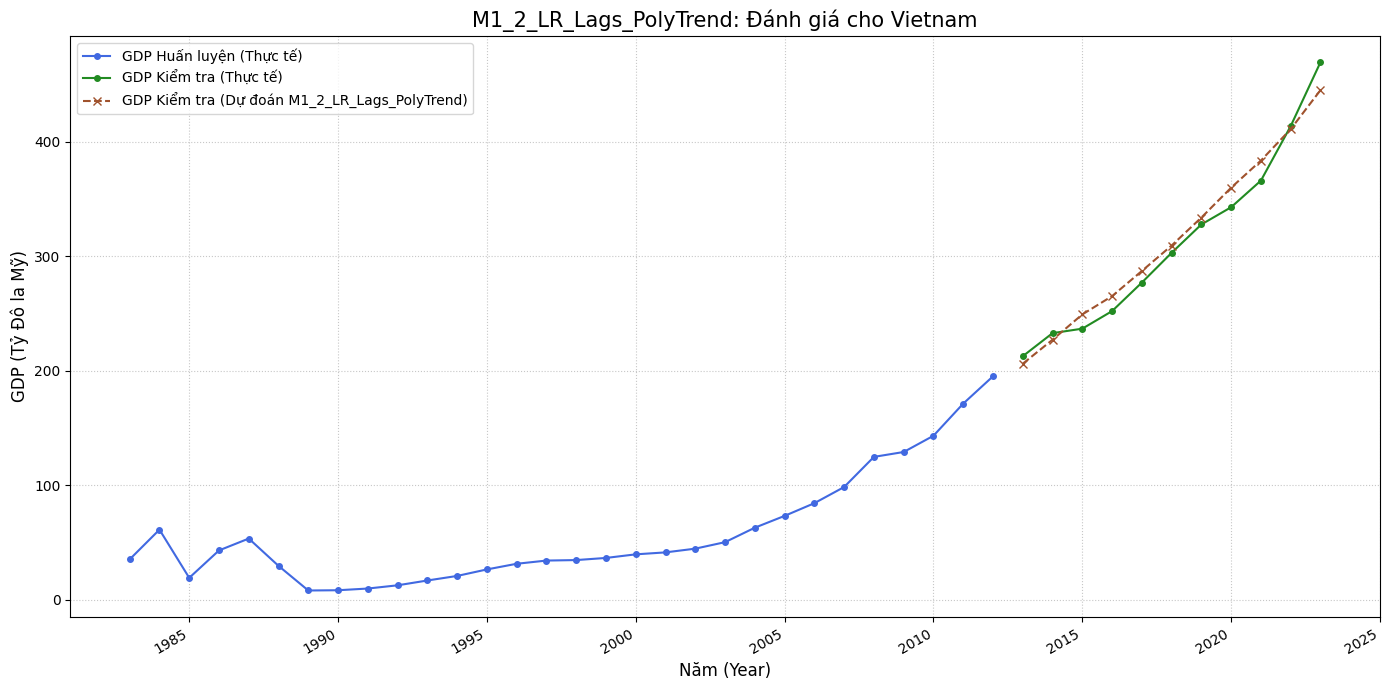

In [12]:
# --- CELL C3.M1_2: {MODEL_ID_M1_2} - ĐÁNH GIÁ MÔ HÌNH (ĐÃ SỬA LỖI MAPE) ---

# Khởi tạo metrics
r2_train_m1_2, mae_train_m1_2, rmse_train_m1_2, mape_train_m1_2 = np.nan, np.nan, np.nan, np.nan
r2_test_m1_2, mae_test_m1_2, rmse_test_m1_2, mape_test_m1_2 = np.nan, np.nan, np.nan, np.nan
y_pred_train_m1_2_orig, y_pred_test_m1_2_orig = None, None 

if 'model_lr_poly_m1_2' in locals() and model_lr_poly_m1_2 is not None and \
   'X_train_m1_2' in locals() and X_train_m1_2 is not None and not X_train_m1_2.empty and \
   'y_train_m1_2' in locals() and y_train_m1_2 is not None and not y_train_m1_2.empty and \
   'X_test_m1_2' in locals() and X_test_m1_2 is not None and not X_test_m1_2.empty and \
   'y_test_m1_2' in locals() and y_test_m1_2 is not None and not y_test_m1_2.empty:
    
    y_pred_train_m1_2_scaled = model_lr_poly_m1_2.predict(X_train_m1_2)
    y_pred_test_m1_2_scaled = model_lr_poly_m1_2.predict(X_test_m1_2)

    # Biến đổi ngược nếu đã dùng log transform
    # actual_use_log_transform được định nghĩa ở Cell C1.M1_2
    if 'actual_use_log_transform' in locals() and actual_use_log_transform:
        # y_train_m1_2 và y_test_m1_2 là Pandas Series
        y_train_m1_2_orig_arr = np.exp(y_train_m1_2.values) # Lấy .values để thành numpy array
        y_pred_train_m1_2_orig_arr = np.exp(y_pred_train_m1_2_scaled)
        y_test_m1_2_orig_arr = np.exp(y_test_m1_2.values)
        y_pred_test_m1_2_orig_arr = np.exp(y_pred_test_m1_2_scaled)
        print("\nĐã thực hiện inverse log transform (np.exp) cho kết quả dự đoán và giá trị thực tế.")
    else:
        y_train_m1_2_orig_arr = y_train_m1_2.values # Chuyển Series thành numpy array
        y_pred_train_m1_2_orig_arr = y_pred_train_m1_2_scaled # Đã là numpy array
        y_test_m1_2_orig_arr = y_test_m1_2.values
        y_pred_test_m1_2_orig_arr = y_pred_test_m1_2_scaled

    # --- Đánh giá trên tập Huấn luyện ---
    print(f"\n--- {MODEL_ID_M1_2}: Đánh giá trên tập Huấn luyện (thang đo gốc) ---")
    r2_train_m1_2 = r2_score(y_train_m1_2_orig_arr, y_pred_train_m1_2_orig_arr)
    mae_train_m1_2 = mean_absolute_error(y_train_m1_2_orig_arr, y_pred_train_m1_2_orig_arr)
    rmse_train_m1_2 = np.sqrt(mean_squared_error(y_train_m1_2_orig_arr, y_pred_train_m1_2_orig_arr))
    try:
        # Tính MAPE trên numpy arrays
        zero_mask_train = (np.abs(y_train_m1_2_orig_arr) < 1e-9)
        y_true_f_train = y_train_m1_2_orig_arr[~zero_mask_train]
        y_pred_f_train = y_pred_train_m1_2_orig_arr[~zero_mask_train]
        if len(y_true_f_train) > 0: 
            mape_train_m1_2 = np.mean(np.abs((y_true_f_train - y_pred_f_train) / y_true_f_train)) * 100
        else: 
            mape_train_m1_2 = np.nan
        
        print(f"R2: {r2_train_m1_2:.4f}, MAE: {mae_train_m1_2:.2f}, RMSE: {rmse_train_m1_2:.2f}", end="")
        if not np.isnan(mape_train_m1_2): print(f", MAPE: {mape_train_m1_2:.2f}% (Tính trên {len(y_true_f_train)} điểm)")
        else: print(", MAPE: Không thể tính")
    except Exception as e: print(f"R2: {r2_train_m1_2:.4f}, MAE: {mae_train_m1_2:.2f}, RMSE: {rmse_train_m1_2:.2f}, Lỗi MAPE (Train): {e}")

    # --- Đánh giá trên tập Kiểm tra ---
    print(f"\n--- {MODEL_ID_M1_2}: Đánh giá trên tập Kiểm tra (thang đo gốc) ---")
    r2_test_m1_2 = r2_score(y_test_m1_2_orig_arr, y_pred_test_m1_2_orig_arr)
    mae_test_m1_2 = mean_absolute_error(y_test_m1_2_orig_arr, y_pred_test_m1_2_orig_arr)
    rmse_test_m1_2 = np.sqrt(mean_squared_error(y_test_m1_2_orig_arr, y_pred_test_m1_2_orig_arr))
    try:
        # Tính MAPE trên numpy arrays
        zero_mask_test = (np.abs(y_test_m1_2_orig_arr) < 1e-9)
        y_true_f_test = y_test_m1_2_orig_arr[~zero_mask_test]
        y_pred_f_test = y_pred_test_m1_2_orig_arr[~zero_mask_test]
        if len(y_true_f_test) > 0: 
            mape_test_m1_2 = np.mean(np.abs((y_true_f_test - y_pred_f_test) / y_true_f_test)) * 100
        else: 
            mape_test_m1_2 = np.nan
        
        print(f"R-squared (Test): {r2_test_m1_2:.4f}")
        print(f"MAE (Test): {mae_test_m1_2:.2f}")
        print(f"RMSE (Test): {rmse_test_m1_2:.2f}")
        if not np.isnan(mape_test_m1_2): 
            print(f"MAPE (Test): {mape_test_m1_2:.2f}% (Tính trên {len(y_true_f_test)} điểm)")
        else: 
            print("MAPE (Test): Không thể tính.")
    except Exception as e:
        print(f"R2 (Test): {r2_test_m1_2:.4f}, MAE (Test): {mae_test_m1_2:.2f}, RMSE (Test): {rmse_test_m1_2:.2f}, Lỗi tính MAPE (Test): {e}")

    # --- Trực quan hóa ---
    # Sử dụng _orig_arr để vẽ, vì chúng là numpy arrays và years_... cũng là numpy arrays hoặc list
    plt.figure(figsize=(14, 7))
    if 'years_train_m1_2' in locals() and years_train_m1_2 is not None and len(years_train_m1_2) == len(y_train_m1_2_orig_arr):
        plt.plot(years_train_m1_2, y_train_m1_2_orig_arr, label='GDP Huấn luyện (Thực tế)', color='royalblue', marker='o', markersize=4)
    else: print("Cảnh báo: Không thể vẽ dữ liệu huấn luyện do 'years_train_m1_2' không khớp hoặc không tồn tại.")

    if 'years_test_m1_2' in locals() and years_test_m1_2 is not None and len(years_test_m1_2) == len(y_test_m1_2_orig_arr):
        plt.plot(years_test_m1_2, y_test_m1_2_orig_arr, label='GDP Kiểm tra (Thực tế)', color='forestgreen', marker='o', markersize=4)
        plt.plot(years_test_m1_2, y_pred_test_m1_2_orig_arr, label=f'GDP Kiểm tra (Dự đoán {MODEL_ID_M1_2})', color='sienna', marker='x', markersize=6, linestyle='--')
    else: print("Cảnh báo: Không thể vẽ dữ liệu kiểm tra do 'years_test_m1_2' không khớp hoặc không tồn tại.")
    
    # actual_use_log_transform được định nghĩa ở Cell C1.M1_2
    y_axis_label = f'GDP{" (Thang đo Log)" if "actual_use_log_transform" in locals() and actual_use_log_transform else ""} (Tỷ Đô la Mỹ)'
    if "actual_use_log_transform" in locals() and actual_use_log_transform:
        y_axis_label = 'GDP (Thang đo Gốc sau khi Inverse Log) (Tỷ Đô la Mỹ)'


    plt.title(f'{MODEL_ID_M1_2}: Đánh giá cho {COUNTRY_M1_2}', fontsize=15)
    plt.xlabel('Năm (Year)', fontsize=12); plt.ylabel(y_axis_label, fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle=':', alpha=0.7); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
else:
    print(f"Mô hình {MODEL_ID_M1_2} chưa được huấn luyện hoặc không có dữ liệu để đánh giá.")



--- M1_2_LR_Lags_PolyTrend: PHÂN TÍCH PHẦN DƯ CHO VIETNAM (Thang đo gốc) ---


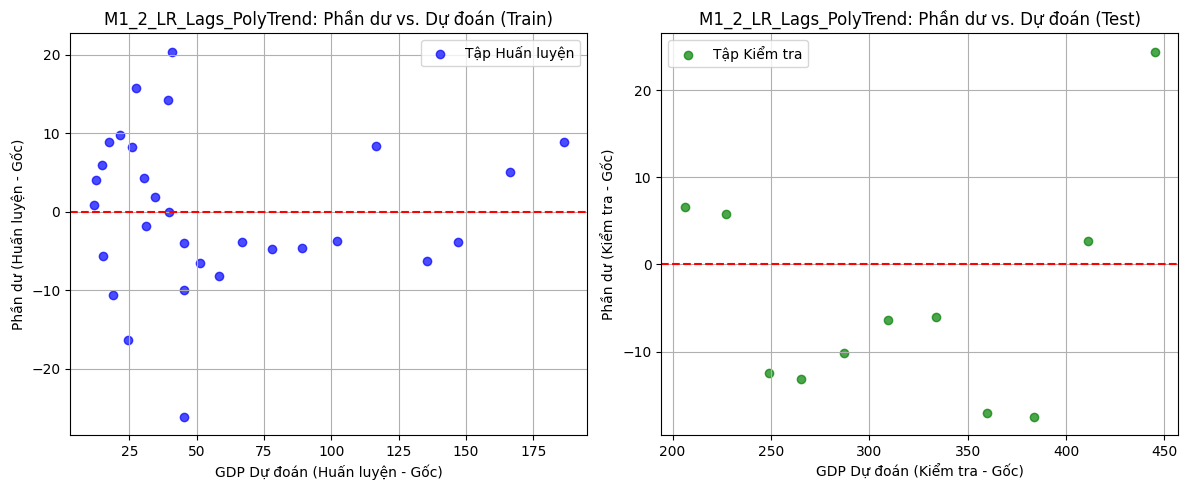

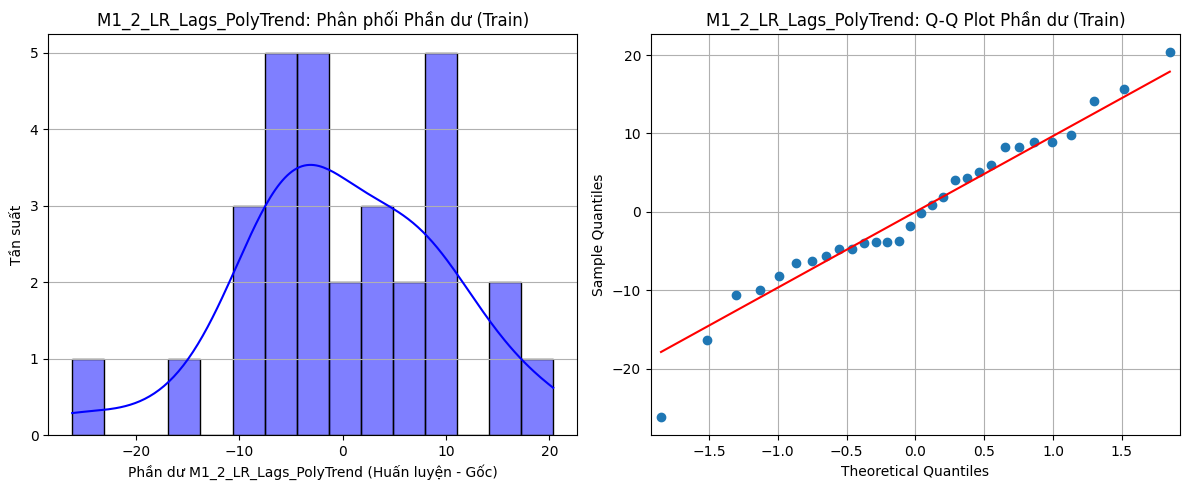

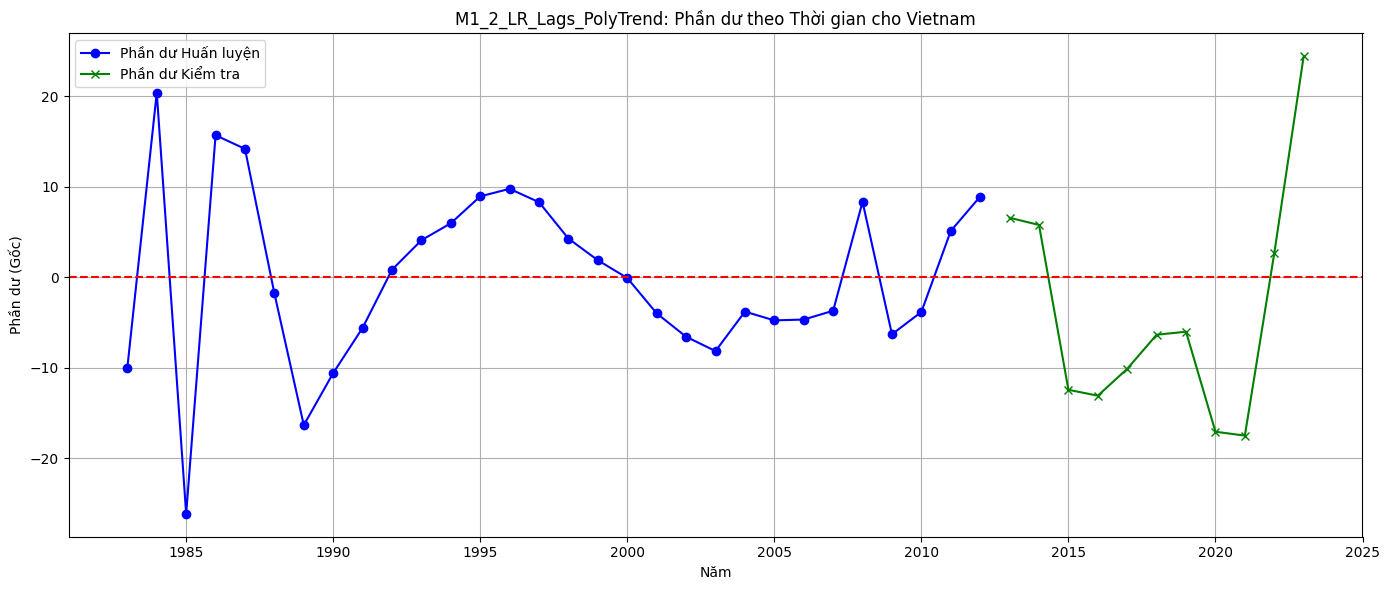

<Figure size 1000x400 with 0 Axes>

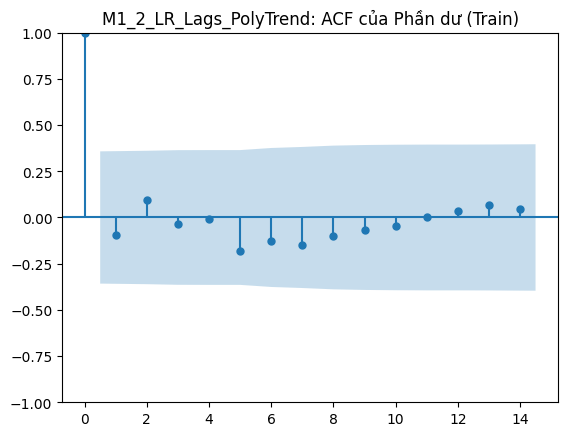

In [13]:
# --- CELL C4.M1_2: {MODEL_ID_M1_2} - PHÂN TÍCH PHẦN DƯ ---

# Sử dụng các biến đã được tính toán và có thể đã inverse_transform từ Cell C3.M1_2
# y_train_m1_2_orig_arr, y_pred_train_m1_2_orig_arr
# y_test_m1_2_orig_arr, y_pred_test_m1_2_orig_arr
# years_train_m1_2, years_test_m1_2

if 'model_lr_poly_m1_2' in locals() and model_lr_poly_m1_2 is not None and \
   'y_train_m1_2_orig_arr' in locals() and y_train_m1_2_orig_arr is not None and \
   'y_pred_train_m1_2_orig_arr' in locals() and y_pred_train_m1_2_orig_arr is not None and \
   'y_test_m1_2_orig_arr' in locals() and y_test_m1_2_orig_arr is not None and \
   'y_pred_test_m1_2_orig_arr' in locals() and y_pred_test_m1_2_orig_arr is not None and \
   'years_train_m1_2' in locals() and years_train_m1_2 is not None and \
   'years_test_m1_2' in locals() and years_test_m1_2 is not None:
    
    print(f"\n\n--- {MODEL_ID_M1_2}: PHÂN TÍCH PHẦN DƯ CHO {COUNTRY_M1_2.upper()} (Thang đo gốc) ---")

    residuals_train_m1_2 = y_train_m1_2_orig_arr - y_pred_train_m1_2_orig_arr
    residuals_test_m1_2 = y_test_m1_2_orig_arr - y_pred_test_m1_2_orig_arr

    # 1. Biểu đồ Phân tán Phần dư (Residuals vs. Predicted Values)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred_train_m1_2_orig_arr, residuals_train_m1_2, alpha=0.7, label='Tập Huấn luyện', color='blue')
    plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('GDP Dự đoán (Huấn luyện - Gốc)'); plt.ylabel('Phần dư (Huấn luyện - Gốc)')
    plt.title(f'{MODEL_ID_M1_2}: Phần dư vs. Dự đoán (Train)'); plt.legend(); plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_test_m1_2_orig_arr, residuals_test_m1_2, alpha=0.7, label='Tập Kiểm tra', color='green')
    plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('GDP Dự đoán (Kiểm tra - Gốc)'); plt.ylabel('Phần dư (Kiểm tra - Gốc)')
    plt.title(f'{MODEL_ID_M1_2}: Phần dư vs. Dự đoán (Test)'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    # 2. Biểu đồ Phân phối của Phần dư (Histogram và Q-Q Plot) - trên tập huấn luyện
    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1)
    sns.histplot(residuals_train_m1_2, bins=15, kde=True, edgecolor='black', color='blue')
    plt.xlabel(f'Phần dư {MODEL_ID_M1_2} (Huấn luyện - Gốc)'); plt.ylabel('Tần suất'); 
    plt.title(f'{MODEL_ID_M1_2}: Phân phối Phần dư (Train)'); plt.grid(axis='y');
    
    plt.subplot(1, 2, 2)
    if len(residuals_train_m1_2) > 0: # sm.qqplot cần dữ liệu
        sm.qqplot(residuals_train_m1_2, line='s', ax=plt.gca()); 
        plt.title(f'{MODEL_ID_M1_2}: Q-Q Plot Phần dư (Train)'); plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Không đủ dữ liệu phần dư train cho Q-Q plot', ha='center', va='center')
        plt.title(f'{MODEL_ID_M1_2}: Q-Q Plot Phần dư (Train)');
    plt.tight_layout(); plt.show()

    # (Tùy chọn: Vẽ tương tự cho residuals_test_m1_2 nếu tập test đủ lớn)

    # 3. Biểu đồ Phần dư theo Thời gian
    plt.figure(figsize=(14, 6))
    if len(years_train_m1_2) == len(residuals_train_m1_2):
        plt.plot(years_train_m1_2, residuals_train_m1_2, marker='o', linestyle='-', color='blue', label='Phần dư Huấn luyện')
    if len(years_test_m1_2) == len(residuals_test_m1_2) and len(residuals_test_m1_2) > 0 :
        plt.plot(years_test_m1_2, residuals_test_m1_2, marker='x', linestyle='-', color='green', label='Phần dư Kiểm tra')
    plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('Năm'); plt.ylabel('Phần dư (Gốc)')
    plt.title(f'{MODEL_ID_M1_2}: Phần dư theo Thời gian cho {COUNTRY_M1_2}'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # 4. ACF của Phần dư (trên tập huấn luyện)
    lags_acf_m1_2 = min(20, max(1, len(residuals_train_m1_2)//2 - 1))
    if lags_acf_m1_2 > 0 and len(residuals_train_m1_2) > lags_acf_m1_2:
        plt.figure(figsize=(10, 4)); plot_acf(residuals_train_m1_2, lags=lags_acf_m1_2, title=f'{MODEL_ID_M1_2}: ACF của Phần dư (Train)'); plt.show()
    elif len(residuals_train_m1_2) > 1: # Nếu residuals_train_m1_2 rất ngắn, lags_acf_m1_2 có thể = 0
        plt.figure(figsize=(10, 4)); plot_acf(residuals_train_m1_2, title=f'{MODEL_ID_M1_2}: ACF của Phần dư (Train)'); plt.show()
    else: 
        print(f"Không đủ dữ liệu phần dư huấn luyện cho ACF của {MODEL_ID_M1_2}.")
else:
    print(f"Mô hình {MODEL_ID_M1_2} chưa có đủ kết quả để phân tích phần dư.")
    print("Kiểm tra xem các biến y_..._orig_arr và years_... có được tạo đúng ở Cell C3.M1_2 không.")


--- M1_2_LR_Lags_PolyTrend: HUẤN LUYỆN LẠI TRÊN TOÀN BỘ DỮ LIỆU (VIETNAM) VÀ DỰ BÁO ---
Thông tin Mô hình 1.2 cuối cùng (huấn luyện trên toàn bộ dữ liệu có sẵn):
  Hệ số chặn (b₀): 1070277.268
  Hệ số cho GDP_lag1: 0.5149
  Hệ số cho GDP_lag2: -0.1902
  Hệ số cho GDP_lag3: 0.1275
  Hệ số cho Year_Feat: -1074.2661
  Hệ số cho Year_Sq_Feat: 0.2696

Bắt đầu dự báo đệ quy cho 5 năm tới (M1_2_LR_Lags_PolyTrend cuối cùng)...
  M1_2_LR_Lags_PolyTrend Dự báo cho năm 2024: 483.624
  M1_2_LR_Lags_PolyTrend Dự báo cho năm 2025: 503.512
  M1_2_LR_Lags_PolyTrend Dự báo cho năm 2026: 535.966
  M1_2_LR_Lags_PolyTrend Dự báo cho năm 2027: 568.980
  M1_2_LR_Lags_PolyTrend Dự báo cho năm 2028: 601.182

--- M1_2_LR_Lags_PolyTrend: Dự báo GDP cho các năm tương lai (Vietnam - Thang đo gốc) ---


,Year,Predicted_GDP
0,2024,483.623707
1,2025,503.511551
2,2026,535.965770
3,2027,568.979739
4,2028,601.181607


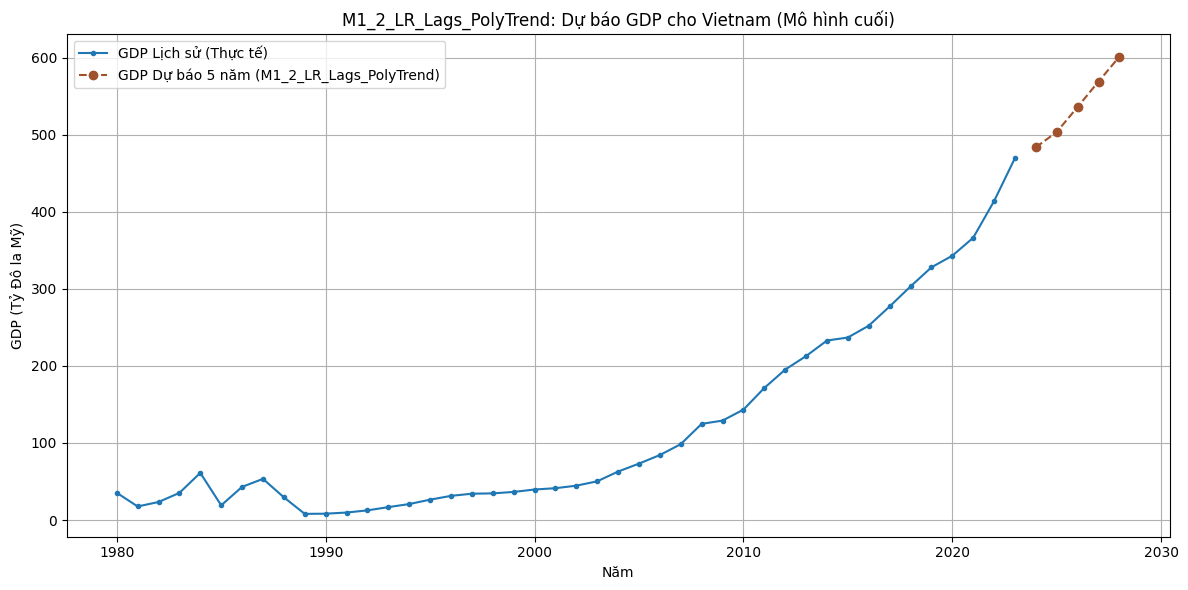


--- KẾT THÚC M1_2_LR_Lags_PolyTrend ---


In [14]:
# --- CELL C5.M1_2: {MODEL_ID_M1_2} - HUẤN LUYỆN LẠI VÀ DỰ BÁO TƯƠNG LAI ---

model_lr_poly_final_m1_2 = None
forecast_lr_poly_future_orig_m1_2 = None # Sẽ lưu dự báo ở thang đo gốc

# Kiểm tra các biến cần thiết từ các cell trước
# X_m1_2, y_m1_2 là dữ liệu đã xử lý (dropna) cho toàn bộ lịch sử của quốc gia
# country_data_lr_m1_2 là dữ liệu của quốc gia trước khi dropna, chứa 'Year' và 'GDP'/'GDP_Log' gốc
# feature_columns_m1_2 là danh sách tên các cột đặc trưng
# actual_use_log_transform_m1_2 (đổi tên từ actual_use_log_transform để rõ ràng hơn cho mô hình này)
# current_lr_poly_params_m1_2 (nếu bạn có cơ chế lưu tham số tối ưu, nếu không thì khởi tạo lại model)

# Đảm bảo biến actual_use_log_transform_m1_2 được truyền từ Cell C1.M1_2
# Nếu không, bạn cần định nghĩa lại nó ở đây hoặc giả định một giá trị
if 'actual_use_log_transform' not in locals() and 'USE_LOG_TRANSFORM_M1_2' in locals():
    # Giả định lại dựa trên cờ ở Cell C1 nếu 'actual_use_log_transform' không được truyền qua context
    # Điều này không lý tưởng, tốt nhất là truyền biến này qua các cell
    print("Cảnh báo: Biến 'actual_use_log_transform' không tìm thấy, sẽ dựa vào 'USE_LOG_TRANSFORM_M1_2'.")
    actual_use_log_transform_m1_2 = USE_LOG_TRANSFORM_M1_2
elif 'actual_use_log_transform' in locals():
    actual_use_log_transform_m1_2 = actual_use_log_transform
else:
    actual_use_log_transform_m1_2 = False # Mặc định nếu không có thông tin


if 'X_m1_2' in locals() and X_m1_2 is not None and \
   'y_m1_2' in locals() and y_m1_2 is not None and \
   'country_data_lr_m1_2' in locals() and country_data_lr_m1_2 is not None and \
   'feature_columns_m1_2' in locals() and not X_m1_2.empty:
    
    print(f"\n--- {MODEL_ID_M1_2}: HUẤN LUYỆN LẠI TRÊN TOÀN BỘ DỮ LIỆU ({COUNTRY_M1_2.upper()}) VÀ DỰ BÁO ---")
    
    # Huấn luyện lại mô hình trên toàn bộ X_m1_2 và y_m1_2
    model_lr_poly_final_m1_2 = LinearRegression()
    model_lr_poly_final_m1_2.fit(X_m1_2, y_m1_2) 
    
    print("Thông tin Mô hình 1.2 cuối cùng (huấn luyện trên toàn bộ dữ liệu có sẵn):")
    print(f"  Hệ số chặn (b₀): {model_lr_poly_final_m1_2.intercept_:.3f}")
    for i, coef_val in enumerate(model_lr_poly_final_m1_2.coef_):
        print(f"  Hệ số cho {feature_columns_m1_2[i]}: {coef_val:.4f}")

    # Dự báo cho tương lai (đệ quy)
    last_known_year_hist_m1_2 = country_data_lr_m1_2['Year'].max() 
    
    # Sử dụng Series với index là Year để dễ dàng truy cập lags
    # target_gdp_col_m1_2 được xác định ở Cell C1.M1_2 (là 'GDP' hoặc 'GDP_Log')
    target_gdp_col_for_hist = 'GDP_Log' if actual_use_log_transform_m1_2 else 'GDP'
    if target_gdp_col_for_hist not in country_data_lr_m1_2.columns:
        print(f"Lỗi: Cột mục tiêu '{target_gdp_col_for_hist}' không tìm thấy trong country_data_lr_m1_2 để tạo lịch sử dự báo.")
    else:
        gdp_history_for_forecast_m1_2 = pd.Series(
            country_data_lr_m1_2[target_gdp_col_for_hist].values, 
            index=country_data_lr_m1_2['Year']
        )
        
        future_predictions_list_scaled_m1_2 = [] # Sẽ lưu dự báo ở thang đo đã transform (nếu có)
        print(f"\nBắt đầu dự báo đệ quy cho {N_FUTURE_YEARS_M1_2} năm tới ({MODEL_ID_M1_2} cuối cùng)...")

        for i in range(N_FUTURE_YEARS_M1_2):
            year_to_predict = last_known_year_hist_m1_2 + 1 + i
            
            current_feature_values = {}
            possible_to_predict = True

            # 1. Tạo Lags (từ gdp_history_for_forecast_m1_2, đang ở thang đo scaled nếu có log)
            for lag_idx in range(1, NUM_LAGS_M1_2 + 1):
                lag_year = year_to_predict - lag_idx
                col_name_lag = f'{target_gdp_col_for_hist}_lag{lag_idx}' # Tên cột lag phải khớp
                if lag_year in gdp_history_for_forecast_m1_2.index:
                    current_feature_values[col_name_lag] = gdp_history_for_forecast_m1_2[lag_year]
                else:
                    possible_to_predict = False; break
            if not possible_to_predict:
                print(f"  Không thể tạo đủ lags cho năm {year_to_predict}. Dừng dự báo."); break

            # 2. Tạo đặc trưng Năm, Năm^2, Năm^3
            if POLY_DEGREE_M1_2 >= 1: current_feature_values['Year_Feat'] = year_to_predict
            if POLY_DEGREE_M1_2 >= 2: current_feature_values['Year_Sq_Feat'] = year_to_predict ** 2
            if POLY_DEGREE_M1_2 >= 3: current_feature_values['Year_Cub_Feat'] = year_to_predict ** 3
            
            features_for_prediction_list = [current_feature_values[col] for col in feature_columns_m1_2]
            features_for_prediction_df = pd.DataFrame([features_for_prediction_list], columns=feature_columns_m1_2)
            
            predicted_gdp_scaled = model_lr_poly_final_m1_2.predict(features_for_prediction_df)[0]
            future_predictions_list_scaled_m1_2.append({'Year': year_to_predict, 'Predicted_GDP_Scaled': predicted_gdp_scaled})
            
            # Cập nhật lịch sử GDP (ở thang đo scaled) với giá trị vừa dự đoán
            gdp_history_for_forecast_m1_2[year_to_predict] = predicted_gdp_scaled
            
            # In dự báo ở thang đo gốc nếu có log transform
            if actual_use_log_transform_m1_2:
                print(f"  {MODEL_ID_M1_2} Dự báo cho năm {year_to_predict}: {np.exp(predicted_gdp_scaled):.3f} (Gốc), {predicted_gdp_scaled:.3f} (Log)")
            else:
                print(f"  {MODEL_ID_M1_2} Dự báo cho năm {year_to_predict}: {predicted_gdp_scaled:.3f}")


        if future_predictions_list_scaled_m1_2:
            future_df_scaled_m1_2 = pd.DataFrame(future_predictions_list_scaled_m1_2)
            
            # Biến đổi ngược về thang đo gốc nếu cần
            if actual_use_log_transform_m1_2:
                future_df_final_m1_2 = future_df_scaled_m1_2.copy()
                future_df_final_m1_2['Predicted_GDP'] = np.exp(future_df_scaled_m1_2['Predicted_GDP_Scaled'])
            else:
                future_df_final_m1_2 = future_df_scaled_m1_2.rename(columns={'Predicted_GDP_Scaled': 'Predicted_GDP'})

            print(f"\n--- {MODEL_ID_M1_2}: Dự báo GDP cho các năm tương lai ({COUNTRY_M1_2} - Thang đo gốc) ---")
            display(future_df_final_m1_2[['Year', 'Predicted_GDP']])

            plt.figure(figsize=(12,6))
            # Vẽ lịch sử GDP gốc (không phải log)
            plt.plot(country_data_lr_m1_2['Year'], country_data_lr_m1_2['GDP'], label='GDP Lịch sử (Thực tế)', marker='.')
            plt.plot(future_df_final_m1_2['Year'], future_df_final_m1_2['Predicted_GDP'], label=f'GDP Dự báo {len(future_df_final_m1_2)} năm ({MODEL_ID_M1_2})', color='sienna', linestyle='--', marker='o')
            
            y_axis_label_final = f'GDP{" (Log Scale đã Inverse)" if actual_use_log_transform_m1_2 else ""} (Tỷ Đô la Mỹ)'
            if actual_use_log_transform_m1_2: y_axis_label_final = 'GDP (Thang đo Gốc sau Inverse Log) (Tỷ Đô la Mỹ)'

            plt.title(f'{MODEL_ID_M1_2}: Dự báo GDP cho {COUNTRY_M1_2} (Mô hình cuối)'); plt.xlabel('Năm'); plt.ylabel(y_axis_label_final); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
        else:
            print(f"Không có dự báo nào được tạo cho {MODEL_ID_M1_2}.")
else:
    print(f"{MODEL_ID_M1_2} chưa có đủ dữ liệu hoặc các biến cần thiết để huấn luyện lại và dự báo.")

print(f"\n--- KẾT THÚC {MODEL_ID_M1_2} ---")